Aimed at mapping global importance values to clusters.
SST, swvl4, t850 and snowc are interesting for respagg 31 > q0.66

In [1]:
import sys
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from pathlib import Path
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.utils import collapse_restore_multiindex, get_nhplus, get_nhmin, get_nhblock, get_europe
from Weave.models import HybridExceedenceModel

from Weave.inspection import ImportanceData, MapInterface, mapplot, FacetMapResult

In [2]:
# Latest results:
quantile = 0.666 # options: 0.666 and 0.8
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
respagg = 31
separation = -15

basepath = Path('/nobackup_1/users/straaten/')
inputpath = basepath / 'clusters_cv_spearmanpar_varalpha_strict' # Latest dimreduced X and y data 
anompath = basepath / 'processed'

permtrainpath = basepath / f'permimp_train_q0{str(quantile)[2:]}'
permtrain = ImportanceData(permtrainpath, respagg, separation, quantile, model)
permtrain.load_data(inputpath=inputpath, X_too = True, y_too = True)
permtrain.scale_within(fill_na = True)

shaptrainpath = basepath / f'shap_stdback_train_q0{str(quantile)[2:]}'
shaptrain = ImportanceData(shaptrainpath, respagg, separation, quantile, model)
shaptrain.load_data(inputpath=inputpath, X_too = True, y_too = True)
shaptrain.global_shap()
shaptrain.df = shaptrain.df * 100

shapvalpath = basepath / f'shap_stdback_val_q0{str(quantile)[2:]}'

### Illustration data
Tcc chosen for its slight (not large separation) importance. And consistency of correlation patterns.

In [36]:
def accumulate(listofarrays, how: str = 'max', min_folds: int = None):
    """
    Tries to remove the fold dimension. By counting how many times each cell in the fold, and getting the mean or max.
    returns list of two dataarrays (first count, second the summary statistic).
    """
    stacked = xr.concat(listofarrays, dim = 'fold')
    count = stacked.count(dim = 'fold')
    count = count.where(count != 0, np.nan)
    count.name = 'count'
    count.attrs.update(dict(units = ""))
    f = getattr(stacked, how)
    stat = f(dim = 'fold')
    if not min_folds is None:
        stat = stat.where(count >= min_folds, np.nan) # where larger or equal, keep the value
    stat.name = how
    stat.attrs.update(dict(units = ""))
    return [count, stat]

def makemaps(mapint, imps: pd.Series, inputtimescale = 31, acckwargs = dict(how = 'max', min_folds = None)):
    variables = ['sst_nhplus', 't850_nhblock','snowc_nhmin','siconc_nhmin'] # 'swvl4_europe'
    new_list = [] # will be dimension of variables
    for var in variables:
        if var == 't850_nhblock':
            metricsep = imps.index.get_loc_level('mean','metric')[0]
        else:
            metricsep = imps.index.get_loc_level('spatcov','metric')[0]
        frame = imps.loc[metricsep].loc[(slice(None),slice(None),[var],[31])]
        maps = mapint_perm.map_to_fields(frame)
        new_list.append(accumulate(maps.listofarrays, **acckwargs))
    return FacetMapResult(rowkeys = variables, listofarrays = new_list, columnkeys = ['count',acckwargs['how']])

In [12]:
mapint_perm = MapInterface(corclustpath=inputpath, anompath= anompath, impdata=permtrain)

In [37]:
permimps = makemaps(mapint_perm, imps = permtrain.df[('multipass','rank')], acckwargs = dict(how = 'mean', min_folds = 4))
#mapplot(permimps)
shaps = makemaps(mapint_perm, imps = shaptrain.df['avgabsshap'], acckwargs=dict(how = 'mean', min_folds = 4))
#mapplot(shaps)

Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


(<Figure size 576x252 with 4 Axes>,
 array([[<GeoAxesSubplot:title={'center':'timeagg = 31, separation = -15'}, ylabel='swvl4'>,
         <GeoAxesSubplot:title={'center':'timeagg = 31, separation = -15'}>]],
       dtype=object))

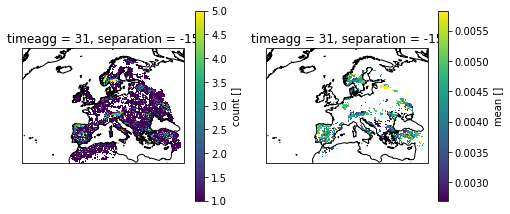

In [164]:
mapplot(FacetMapResult(['swvl4'],[shaps.listofarrays[-1]],columnkeys = ['count','mean']), region = get_europe())

In [ ]:
def data_for_pcolormesh(array):
    """Xarray array to usuable things"""
    lats = array.latitude.values # Interpreted as northwest corners (90 is in there)
    lons = array.longitude.values # Interpreted as northwest corners (-180 is in there, 180 not)
    lats = np.concatenate([lats[[0]] - np.diff(lats)[0], lats], axis = 0) # Adding the sourthern edge 
    lons = np.concatenate([lons, lons[[-1]] + np.diff(lons)[0]], axis = 0)# Adding the eastern edge
    return lons, lats, array.values

region = get_nhplus()
extent = np.array(region[1:])[[1,3,2,0]]  # (-180,180,-40,80) drop the name and reorder to x0,x1,y0,y1
#region_t850 = get_nhblock()
#extent_t850 = np.array(region_t850[1:])[[1,3,2,0]] 
region_snow = get_nhmin()
extent_snow = np.array(region_snow[1:])[[1,3,2,0]]  # drop the name and reorder to x0,x1,y0,y1
extent_siconc = (-180,180,65,90)  # drop the name and reorder to x0,x1,y0,y1
array_crs = ccrs.PlateCarree()
proj = ccrs.Robinson() #ccrs.PlateCarree() #ccrs.Mollweide()
proj_snow = ccrs.Orthographic(0,90)
snowrow = permimps.rowkeys.index('snowc_nhmin')
siconcrow = permimps.rowkeys.index('siconc_nhmin')
#t850row = permimps.rowkeys.index('t850_nhblock')

fig = plt.figure(figsize = (12,9))
nvars = len(permimps.listofarrays)
gs = GridSpec(ncols=3, nrows = nvars + 1, hspace = .05, wspace = 0.03, height_ratios=[0.9,0.9,1.2,1.2,0.1])
axes = np.full((nvars,gs.ncols),None, dtype = 'object')
ims = np.full((nvars,gs.ncols),None, dtype = 'object')
for rowind,colind in itertools.product(range(axes.shape[0]),range(axes.shape[1])):
    if rowind == snowrow:
        axes[rowind,colind] = fig.add_subplot(gs[rowind,colind],projection=proj_snow)
        axes[rowind,colind].set_extent(tuple(extent_snow), crs = array_crs)
    elif rowind == siconcrow:
        axes[rowind,colind] = fig.add_subplot(gs[rowind,colind],projection=proj_snow)
        axes[rowind,colind].set_extent(tuple(extent_siconc), crs = array_crs)
    #elif rowind == t850row:
    #    axes[rowind,colind] = fig.add_subplot(gs[rowind,colind],projection=proj)
    #    axes[rowind,colind].set_extent(tuple(extent_t850), crs = array_crs)
    else:
        axes[rowind,colind] = fig.add_subplot(gs[rowind,colind],projection=proj)
        axes[rowind,colind].set_extent(tuple(extent), crs = array_crs)
    if colind == 0:
        field = permimps.listofarrays[rowind][colind]
        vmin, vmax = (0,5) # Counts
    elif colind == 1:
        field = permimps.listofarrays[rowind][1]
        vmin, vmax = (0,1) # scaled multipass
    else:
        field = shaps.listofarrays[rowind][1]
        vmin, vmax = (0,4) # shap (multiplied by 100)
    #axes[rowind,colind].stock_img()
    #axes[rowind,colind].coastlines(color = 'black')
    ims[rowind,colind] = axes[rowind,colind].pcolormesh(*data_for_pcolormesh(field), shading = 'flat', transform = array_crs, cmap = 'plasma', vmin = vmin, vmax = vmax)

cax_count = fig.add_subplot(gs[-1,0])
cbar_count = fig.colorbar(ims[-1,0], cax = cax_count, orientation = 'horizontal', label = 'number of folds')
cax_perm = fig.add_subplot(gs[-1,1])
cbar_perm = fig.colorbar(ims[-1,1], cax = cax_perm, orientation = 'horizontal', label = 'permutation importance [rank]')
cax_shap = fig.add_subplot(gs[-1,2])
cbar_shap = fig.colorbar(ims[-1,2], cax = cax_shap, orientation = 'horizontal', label = 'TreeSHAP contribution [%]', extend = 'max')

#plt.savefig('/usr/people/straaten/Pictures/global_geo_imp_cbar.png', dpi = 140)
#plt.show()

## Case study

In [3]:
quantile = 0.666
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 7, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shapvalpath, respagg=[31], separation= [-15], quantile = quantile, model=model)
shaps.load_data(X_too = True, y_too = True, inputpath = inputpath)
mapint = MapInterface(corclustpath=inputpath, anompath= anompath, impdata=shaps)

In [4]:
summer = '2015'
moment1 = pd.Timestamp(f'{summer}-06-06')
moment2 = pd.Timestamp(f'{summer}-07-16')

In [54]:
sst_sample1 = shaps.df.loc[([31],[4],['sst_nhplus'],[31,21],slice(None),[-15],[1,4],'spatcov'),[moment1]]
sst_sample1 = sst_sample1.iloc[[0,-1],:] # Bit of a shortcut to select only those clustid combinations
sst_maps1 = mapint.get_anoms(imp=sst_sample1, mask_with_clustid=True, mask_strict = True)
siconc_sample1 = shaps.df.loc[([31],[4],['siconc_nhmin'],[31],slice(None),[-15],1,'spatcov'),[moment1]]
siconc_maps1 = mapint.get_anoms(imp=siconc_sample1, mask_with_clustid=True, mask_strict = True)

In [55]:
sst_sample = shaps.df.loc[([31],[4],['sst_nhplus'],[31,21],slice(None),[-15],[1,4],'spatcov'),[moment2]]
sst_sample = sst_sample.iloc[[0,-1],:]
sst_maps = mapint.get_anoms(imp=sst_sample, mask_with_clustid=True, mask_strict = True)
siconc_sample = shaps.df.loc[([31],[4],['siconc_nhmin'],[31],slice(None),[-15],1,'spatcov'),[moment2]]
siconc_maps = mapint.get_anoms(imp=siconc_sample, mask_with_clustid=True, mask_strict = True)

In [56]:
arrays = np.full((3,4), None,dtype = 'object')
arrays[0,1:] = sst_maps.listofarrays[1] # moment2 starts 2nd column
arrays[1,1:] = sst_maps.listofarrays[0] 
arrays[2,1:] = siconc_maps.listofarrays[0]
arrays[0,0] = sst_maps1.listofarrays[1][0]
arrays[1,0] = sst_maps1.listofarrays[0][0]
arrays[2,0] = siconc_maps1.listofarrays[0][0]
arrays = arrays.T

In [ ]:
def data_for_pcolormesh(array):
    """Xarray array to usuable things"""
    lats = array.latitude.values # Interpreted as northwest corners (90 is in there)
    lons = array.longitude.values # Interpreted as northwest corners (-180 is in there, 180 not)
    lats = np.concatenate([lats[[0]] - np.diff(lats)[0], lats], axis = 0) # Adding the sourthern edge 
    lons = np.concatenate([lons, lons[[-1]] + np.diff(lons)[0]], axis = 0)# Adding the eastern edge
    return lons, lats, array.values

region = get_nhblock() #
extent = (-130, 70, 15,80) # np.array(region[1:])[[1,3,2,0]]  # drop the name and reorder to x0,x1,y0,y1
extent_snow = (-180,180,70,90) #np.array(region_snow[1:])[[1,3,2,0]]  # drop the name and reorder to x0,x1,y0,y1
extent_21 = (100,200,-40,40)
array_crs = ccrs.PlateCarree()
proj = ccrs.Robinson(-20)
proj_21 = ccrs.Robinson(160)
proj_snow = ccrs.Orthographic(0,90)

fig = plt.figure(figsize = (12,9))
nvars = arrays.shape[1]
gs = GridSpec(ncols=nvars + 1, nrows = 4, hspace = .05, wspace = 0.01, width_ratios=[3,3,1.8,0.15])
axes = np.full((gs.ncols,nvars),None, dtype = 'object')
ims = np.full((gs.ncols,nvars),None, dtype = 'object')
for rowind,colind in itertools.product(range(axes.shape[0]),range(axes.shape[1])):
    if colind == 2:
        axes[rowind,colind] = fig.add_subplot(gs[rowind,colind],projection=proj_snow)
        axes[rowind,colind].set_extent(tuple(extent_snow), crs = array_crs)
    elif colind == 1:
        axes[rowind,colind] = fig.add_subplot(gs[rowind,colind],projection=proj_21)
        axes[rowind,colind].set_extent(tuple(extent_21), crs = array_crs)
    else:
        axes[rowind,colind] = fig.add_subplot(gs[rowind,colind],projection=proj)
        axes[rowind,colind].set_extent(tuple(extent), crs = array_crs)
    if rowind == 0 or rowind == 1:
        vmin, vmax = (-1,1) # anomaly maps
        cmap = 'RdBu_r'
    elif rowind == 2:
        vmin, vmax = (-0.3,0.3) # correlation maps
        cmap = 'RdBu_r'
    else:
        vmin, vmax = (0,8) # scaled multipass
        cmap = 'Set1'
    #axes[rowind,colind].stock_img()
    axes[rowind,colind].coastlines()
    ims[rowind,colind] = axes[rowind,colind].pcolormesh(*data_for_pcolormesh(arrays[rowind,colind]), shading = 'flat', transform = array_crs, cmap = cmap, vmin = vmin, vmax = vmax)

cax_m1 = fig.add_subplot(gs[1,-1]) # gs[0:1,-1]
cbar_m1 = fig.colorbar(ims[1,-1], cax = cax_m1, orientation = 'vertical', label = 'anomaly [K] or [-]', extend = 'both')
cax_corr = fig.add_subplot(gs[2,-1])
cbar_corr = fig.colorbar(ims[2,-1], cax = cax_corr, orientation = 'vertical', label = 'correlation',extend = 'both')
cax_id = fig.add_subplot(gs[-1,-1])
cbar_id = fig.colorbar(ims[-1,-1], cax = cax_id, orientation = 'vertical', label = 'clusterid')

#plt.savefig('/usr/people/straaten/Pictures/case2015_geo_masked.png', dpi = 140)
#plt.show()